In [1]:
import numpy as np
from matplotlib import rcParams, pyplot as plt
import scipy.linalg as la
import MFCC
from sklearn.decomposition import NMF as nmf
import pickle
import scipy.io.wavfile as wavfile
import proj_404 as p
import gmmhmm
%matplotlib inline
rcParams['figure.figsize'] = (12,8)

# Update of Project - Kevin Miller 

In this iPython Notebook I show some of the dealings with the processing of the audio signals that I'm going to be working with. I took 6 different instruments and looked for patterns in the signals/cepstral coefficients/etc. I show the plots of the things that I saw here, and note my conclusions here:

It seems that we can distinguish between instruments by their cepstral coefficients. I believe that building a "library" matrix that contains all the instruments' cepstral coefficients as column vectors, along with some column vectors representing various combinations of instruments, I can then perform NMF on such a matrix to "pull out" feature vectors that will indicate a sort of "basis" for describing linear combinations of instruments in signals. I realize there are a number of nuances still to be figured out with that, but as I've looked at the data and worked with cepstral coefficients, I am hopeful that I can get this to work. 

Also, I of course will be first getting this all to work with a very small instrument set (the 6 instruments here, along with a violin and guitar recording). 

In [2]:
# This is where we will extract our W and H matrices to use in classifying samples later
# This is using the sklearn NMF method
def get_W_H(V, n_components):
    model = nmf(n_components=n_components, init='nndsvd', solver='cd', sparseness='data')
    W = model.fit_transform(V)
    H = model.components_
    return W, H


# Read in the Data, Get the Different Chunks

In [5]:
# Read in the different wav files for a couple of instruments
place = './'
rate, t_sax = wavfile.read(place+'tsax.WAV')
rate, trumpet = wavfile.read(place+'trumpet.WAV')
rate, trombone = wavfile.read(place+'trombone.WAV')
rate, clarinet = wavfile.read(place+'clarinet.WAV')
rate, oboe = wavfile.read(place+'oboe.WAV')
rate, timpani = wavfile.read(place+'timpani.WAV')

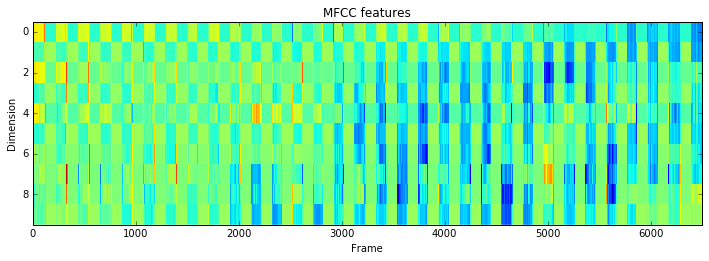

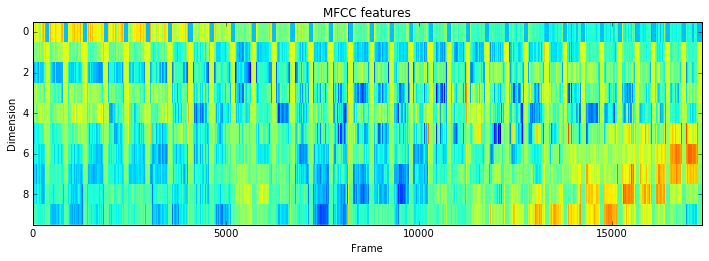

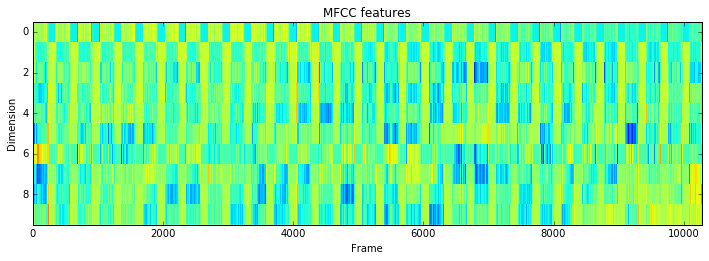

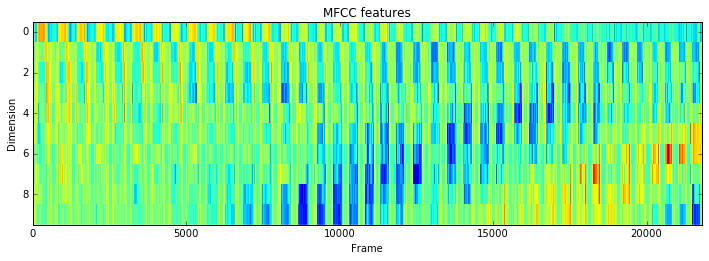

In [4]:
# Here we obtain and plot the MFCC we get from MFCC extract method. Note this is over the WHOLE clip, which includes all the different notes
t_sax_cc = MFCC.extract(t_sax)
plt.show()
trumpet_cc = MFCC.extract(trumpet)
plt.show()
trombone_cc = MFCC.extract(trombone)
plt.show()
clarinet_cc = MFCC.extract(clarinet)
plt.show()

In [4]:
# With this method I am getting the different "chunks" or notes that the track contains

def get_chunks(_signal):
    signal = list(_signal)
    chunks = []
    silence = False
    chunk = []
    while len(signal) > 5000:
        if not silence:
            if signal[:5000] == [0]*5000:
                chunks.append(chunk)
                chunk = []
                silence = True
            else:
                chunk += signal[:5000]
                signal = signal[5000:]
        else:
            if signal[:5000] == [0]*5000:
                signal = signal[5000:]
            else:
                silence = False
    chunk += signal
    chunks.append(chunk)
    return chunks

In [7]:
t_sax_chunks = get_chunks(t_sax)

In [8]:
# Here I get the chunks(notes) from the other instruments 
trumpet_chunks = get_chunks(trumpet)
print 'done trumpet'
trombone_chunks = get_chunks(trombone)
print 'done trombone'
clarinet_chunks = get_chunks(clarinet)
print 'done clarinet'
timpani_chunks = get_chunks(timpani)
print 'done timpani'

done trumpet
done trombone
done clarinet
done timpani


In [9]:
# Make a dictionary that we will store the information of each note for each instrument for later use
chunks_dict = {}
chunks_dict['tenor'] = t_sax_chunks
chunks_dict['trumpet'] = trumpet_chunks
chunks_dict['trombone'] = trombone_chunks
chunks_dict['clarinet'] =clarinet_chunks
chunks_dict['timpani'] = timpani_chunks

In [12]:
rate = 44100
for instrument in chunks_dict.keys():
    for i in xrange(len(chunks_dict[instrument])):
        name = instrument + '_' + str(i) +'.wav'
        data = np.array(chunks_dict[instrument][i])
        wavfile.write(name, rate, data)
    print 'done with ' + instrument

done with trombone
done with clarinet
done with timpani
done with trumpet
done with tenor


In [13]:
# Process more instruments
rate, voice = wavfile.read(place+'voice.WAV')
rate, violin = wavfile.read(place+'violin.WAV')
rate, flute = wavfile.read(place+'flute.WAV')

violin_chunks = get_chunks(violin)
print 'done violin'
voice_chunks = get_chunks(voice)
print 'done voice'
flute_chunks = get_chunks(flute)
print 'done flute'

chunks_dict['flute'] = flute_chunks
chunks_dict['voice'] = voice_chunks
chunks_dict['violin'] = violin_chunks

done violin
done voice
done voice


In [14]:
for instrument in ['violin', 'flute', 'voice']:
    for i in xrange(len(chunks_dict[instrument])):
        name = instrument + '_' + str(i) +'.wav'
        data = np.array(chunks_dict[instrument][i])
        wavfile.write(name, rate, data)
    print 'done with ' + instrument

done with violin
done with flute
done with voice


# Identifying if a TENOR SAX is playing in a clip


In [16]:
reload(MFCC)
reload(p)

<module 'proj_404' from 'proj_404.py'>

In [17]:
rate, tenor_clip = wavfile.read('./Chunks/tenor_4.wav')
tenor_sax_sig = p.Signal(rate, tenor_clip)


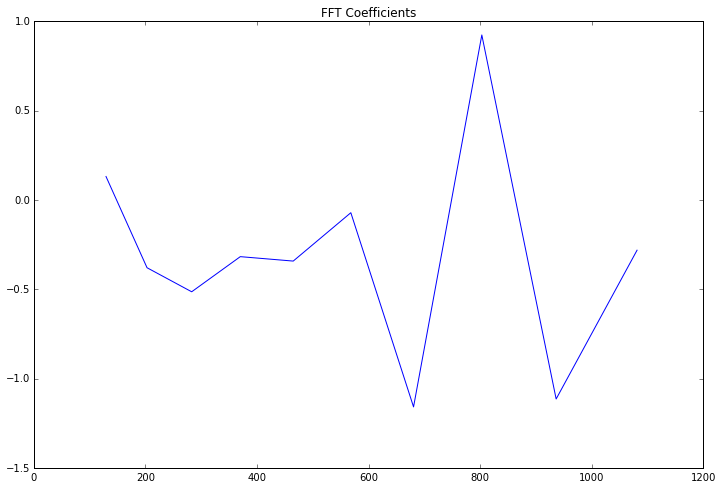

In [18]:
tenor_sax_sig.plot_middle_mfcc()


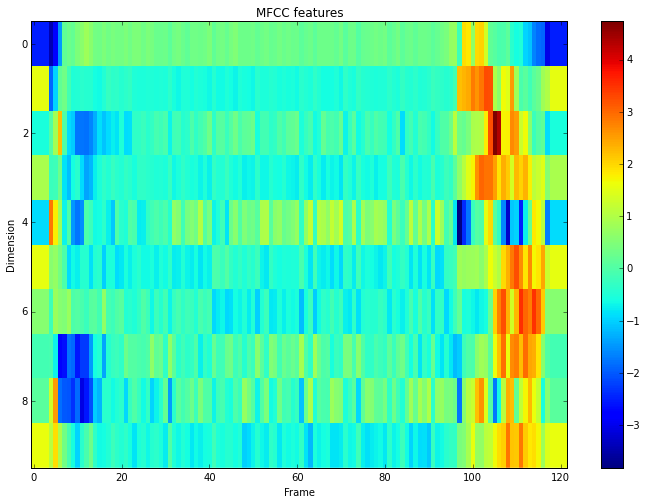

In [19]:
tenor_sax_sig.plot_mfcc_id()

In [9]:
# Function for initializing the parameters for our GMMHMM on the given instrument
def initialize(n):
    startprob = np.random.rand(n)
    startprob /= np.sum(startprob)
    transmat = np.random.rand(n).reshape(1,n)
    transmat /= np.sum(transmat)
    for i in xrange(1,n):
        row = np.random.rand(n).reshape(1,n)
        row /= np.sum(row)
        transmat = np.vstack((transmat,row))
    
    return startprob, transmat

In [15]:
# Get the tenor MFCC's
tenor_clips = []
done = False
i = 0
while not done:
    try:
        rate, tenor_clip = wavfile.read('./Chunks/tenor_'+ str(i) + '.wav')
        tenor_clips.append(MFCC.extract(tenor_clip))
        i += 1
    except:
        done = True

    

In [16]:
# Get the trumpet MFCC's
trumpet_clips = []
done = False
i = 0
while not done:
    try:
        rate, trumpet_clip = wavfile.read('./Chunks/trumpet_'+ str(i) + '.wav')
        trumpet_clips.append(MFCC.extract(trumpet_clip))
        i += 1
    except:
        done = True

MFCC.py:98: RuntimeWarning: invalid value encountered in divide
  feature = (feature - mu) / sigma


In [17]:
# Partition the clips into training and testing samples
tenor_training = tenor_clips[:20]
tenor_test = tenor_clips[20:]

In [18]:
# Partition the clips into training and testing samples
trumpet_training = trumpet_clips[:20]
trumpet_test = trumpet_clips[20:]


In [34]:
tenor_model = get_best_model(tenor_training)

0
1
2
3
4


In [39]:
trumpet_model = get_best_model(trumpet_training)

0
1
2
3
4


In [7]:
# Train best model, 5 different times, keep the best model
def get_best_model(training_set):
    # Instantiate variables
    best_score = -np.inf
    best_model = None
    for i in xrange(5):
        # Print what iteration we're on -- this is for me to know how long the process will take
        print i
    
        # Get initial parameters
        startprob, transmat = initialize(10)
    
        # Train our model for this iteration
        model = gmmhmm.GMMHMM(n_components=10, n_mix=5, transmat=transmat, startprob=startprob, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(training_set, init_params='mc', var=0.1)
        
        # Get the logprob (ie the score) for this model. If the score is better, then current model is set as best model
        model_score = model.logprob
        if model_score > best_score:
            best_model = model
            best_score = model_score
        
    return best_model

In [43]:
# Try some simple classification examples - Will our models tell the difference between saxophone and trumpet?
tenor_results = []
for test in tenor_test:
    tenor_score = tenor_model.score(test)
    trumpet_score = trumpet_model.score(test)
    if tenor_score > trumpet_score:
        print 'Success!'
        tenor_results.append(1)
    else:
        print 'Fail'
        tenor_results.append(0)

trumpet_results = []
for test in trumpet_test:
    try:
        tenor_score = tenor_model.score(test)
        trumpet_score = trumpet_model.score(test)
        if trumpet_score > tenor_score:
            print 'Success!'
            trumpet_results.append(1)
        else:
            print 'Fail'
            trumpet_results.append(0)
    except:
        print 'error - continuing on'
    

Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Fail
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
error - continuing on


# Pickling the Models

In [59]:
f = open('tenor_model.p','w')
pickle.dump(tenor_model, f)
f.close()

In [60]:
f = open('trumpet_model.p','w')
pickle.dump(trumpet_model, f)
f.close()

In [2]:
# To load in the tenor model! Similar for the trumpet model
TENORMODEL = pickle.load(open('tenor_model.p', 'rb'))

In [3]:
TRUMPETMODEL = pickle.load(open('trumpet_model.p', 'rb'))

In [4]:
# Get the trombone MFCC's
trombone_clips = []
done = False
i = 0
while not done:
    try:
        rate, trombone_clip = wavfile.read('./Chunks/trombone_'+ str(i) + '.wav')
        trombone_clips.append(MFCC.extract(trombone_clip))
        i += 1
    except:
        done = True

        
clarinet_clips = []
done = False
i = 0
while not done:
    try:
        rate, clarinet_clip = wavfile.read('./Chunks/clarinet_'+ str(i) + '.wav')
        clarinet_clips.append(MFCC.extract(clarinet_clip))
        i += 1
    except:
        done = True

flute_clips = []
done = False
i = 0
while not done:
    try:
        rate, flute_clip = wavfile.read('./Chunks/flute_'+ str(i) + '.wav')
        flute_clips.append(MFCC.extract(flute_clip))
        i += 1
    except:
        done = True

In [5]:
# Partition the clips into training and testing samples
trombone_training = trombone_clips[:20]
trombone_test = trombone_clips[20:]
clarinet_training = clarinet_clips[:20]
clarinet_test = clarinet_clips[20:]
flute_training = flute_clips[:20]
flute_test = flute_clips[20:]

In [10]:
# train the other models
trombone_model = get_best_model(trombone_training)
print 'done with trombone'
clarinet_model = get_best_model(clarinet_training)
print 'done with clarinet'
flute_model = get_best_model(flute_training)
print 'done with flute'

0
1
2
3
4
done with trombone
0
1
2
3
4
done with clarinet
0
1
2
3
4
done with flute


In [11]:
# Pickle the other models
f = open('trombone_model.p','w')
pickle.dump(trombone_model, f)
f.close()
f = open('clarinet_model.p','w')
pickle.dump(clarinet_model, f)
f.close()
f = open('flute_model.p','w')
pickle.dump(flute_model, f)
f.close()

In [12]:
models = {}
models['tenor'] = TENORMODEL
models['trumpet'] = TRUMPETMODEL
models['trombone'] = trombone_model
models['clarinet'] = clarinet_model
models['flute'] = flute_model

In [19]:
# models is a dictionary, with string key as the name of the instrument
def run_tests(data, models):
    results = []
    for clip in data:
        top_score = -np.inf
        top_inst = None
        for instrument, inst_model in models.iteritems():
            try:
                val = inst_model.score(clip)
                if val > top_score:
                    top_score = val
                    top_inst = instrument
            except:
                print 'something went wrong with this clip, continuing on'
        results.append((top_inst, top_score))
    return results

In [20]:
# Run tenor tests
tenor_results = run_tests(tenor_test, models)


In [21]:
trumpet_results = run_tests(trumpet_test, models)
trombone_results = run_tests(trombone_test, models)
clarinet_results = run_tests(clarinet_test, models)
flute_results = run_tests(flute_test, models)

something went wrong with this clip, continuing on
something went wrong with this clip, continuing on
something went wrong with this clip, continuing on
something went wrong with this clip, continuing on
something went wrong with this clip, continuing on


gmmhmm.py:523: RuntimeWarning: invalid value encountered in greater_equal
  state_idx, = np.nonzero(lattice_frame >= threshlogprob)


In [24]:
print tenor_results
print trumpet_results
print trombone_results

[('tenor', -957.52284709157937), ('flute', -1016.599689624818), ('flute', -1319.8005384222106), ('flute', -1052.0725325368846), ('flute', -1328.406843027424), ('flute', -1297.5652534052128), ('tenor', -1236.872486693168), ('tenor', -1355.5674592005444), ('tenor', -1574.1527579008366), ('flute', -1370.7925330844341), ('flute', -1643.261637606427), ('tenor', -1761.1408559421147)]
[('trumpet', -4649.595519769261), ('trumpet', -4255.9942910178315), ('trumpet', -5412.7879864445067), ('trumpet', -6695.4612649356095), ('trumpet', -6019.7715588003439), ('trumpet', -6605.5583284245704), ('trumpet', -6067.3261407651007), ('trumpet', -5635.7657654537497), ('trumpet', -5106.0092448644218), ('trumpet', -5113.3287795309107), ('flute', -5342.4113174054091), ('trumpet', -4793.9201577665099), ('trumpet', -3412.4460792954137), ('flute', -4269.5064002222716), ('flute', -3762.36872335419), (None, -inf)]
[('trumpet', -2635.8532468640401), ('trombone', -2425.3291374142941), ('trombone', -2013.9932805597537)

# To Do

run stuff with noise, see how well we can predict with noise.

Then combine clips together to see if we can get a threshold for being able to pick out the instruments?

Other techniques? the basis vectors representing the different instruments? The different 

# Comments

There's got to be someway to scale/normalize all these MFCC's for each instrument. I feel that shifting to be around the mean will be more stable like in the PCA sense. But how do I do that with the MFCC's? How do I focus on the shape of the frequency coefficients around the fundamental frequency, when MFCC gives me I think relative characteristic bins?

Also, what the heck does n_mix and n_components do for us in our GMMHMM??? I know n_components represents the number of different "states" that our model can transition through... but what was the significance of 5 for our speech recognition?? I'm changing this to be 10 and then n_mix to be 5... What will this do? What does this represent??? I feel that if my model doesn't work very well, I'm not so sure it's that my idea isn't right, but rather that I don't really get what would be best or what is going on with the module. AND the documentation for gmmhmm.py doesn't even have reference to what n_mix is - I can't find it anywhere..

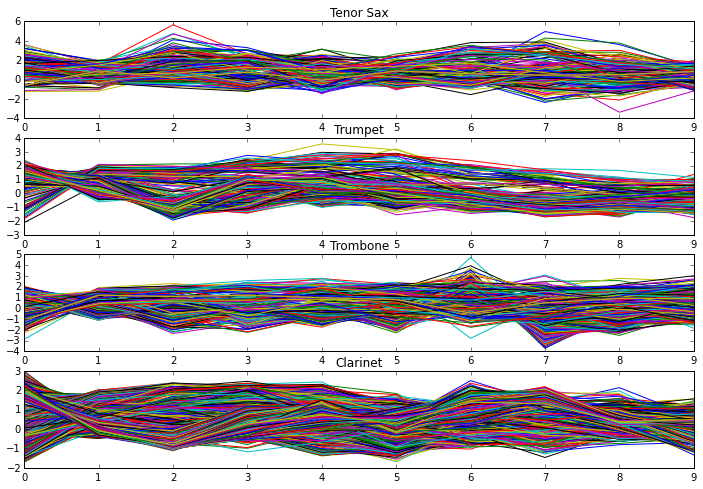

In [62]:
plt.subplot(4,1,1)
for i in xrange(1000):
    plt.plot(np.arange(10), t_sax_cc[i,:])
plt.title('Tenor Sax')
    
plt.subplot(4,1,2)
for i in xrange(1000):
    plt.plot(np.arange(10), trumpet_cc[i,:])
plt.title('Trumpet')
    
plt.subplot(4,1,3)
for i in xrange(1000):
    plt.plot(np.arange(10), trombone_cc[i,:])
plt.title('Trombone')
    
plt.subplot(4,1,4)
for i in xrange(1000):
    plt.plot(np.arange(10), clarinet_cc[i,:])
plt.title('Clarinet')
plt.show()



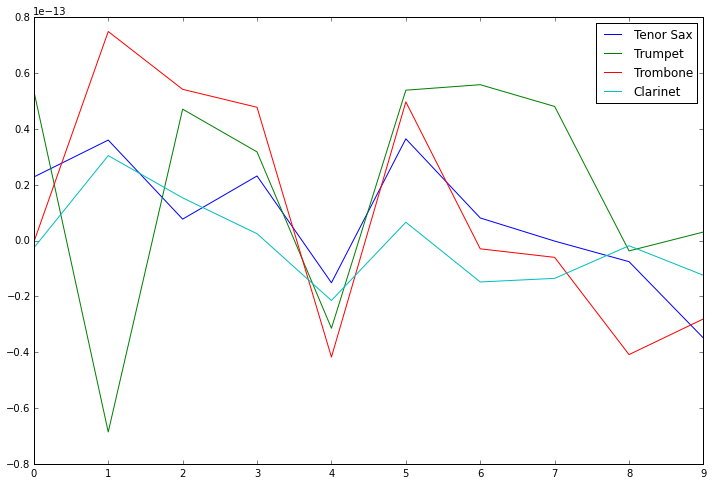

In [63]:
t_sax_cc_avg = np.average(t_sax_cc, axis=0)
plt.plot(np.arange(10), t_sax_cc_avg, label='Tenor Sax')
trumpet_cc_avg = np.average(trumpet_cc, axis=0)
plt.plot(np.arange(10), trumpet_cc_avg, label='Trumpet')
trombone_cc_avg = np.average(trombone_cc, axis=0)
plt.plot(np.arange(10), trombone_cc_avg, label='Trombone')
clarinet_cc_avg = np.average(clarinet_cc, axis=0)
plt.plot(np.arange(10), clarinet_cc_avg, label='Clarinet')
plt.legend()
plt.title
plt.show()


In [14]:
print t_sax_cc[100,:]
print t_sax_cc_avg

# problem -- look at the size of the averages --> they're basically zero... Does this shape really mean anything?
# If we're taking a little clip of music, it's CC's probably won't be that close to 0 like these averages are..


[ 2.19409453 -0.29792479  2.10344527 -0.355645    1.73501649 -0.64377519
  0.73740718  0.75795198  0.4634927  -0.33021052]
[  2.28032294e-14   3.60304436e-14   7.70059230e-15   2.31588424e-14
  -1.51077100e-14   3.64817578e-14   8.11436388e-15  -1.74851586e-16
  -7.55081467e-15  -3.49336970e-14]


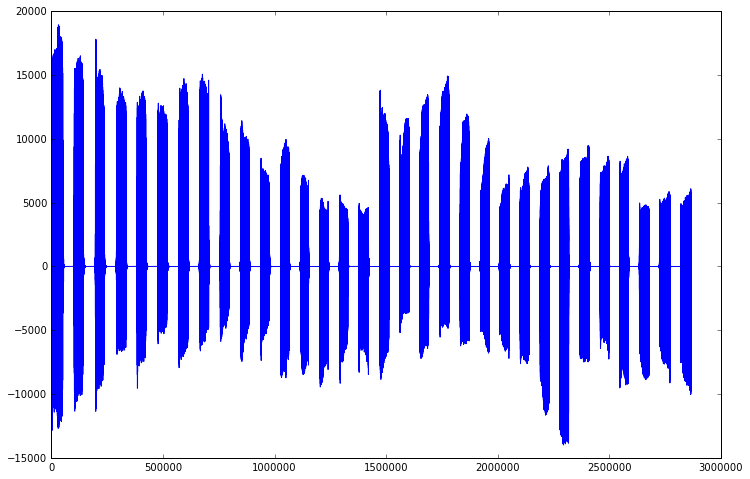

In [5]:
plt.plot(np.arange(len(t_sax)), t_sax)
plt.show()

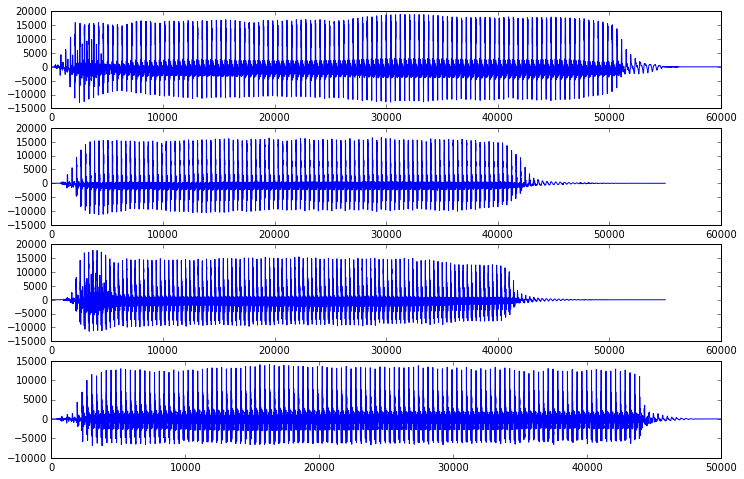

In [8]:
# Here I am checking that I got good chunks from my chunk method

plt.subplot(4,1,1)
plt.plot(np.arange(len(t_sax_chunks[0])), t_sax_chunks[0])
plt.subplot(4,1,2)
plt.plot(np.arange(len(t_sax_chunks[1])), t_sax_chunks[1])
plt.subplot(4,1,3)
plt.plot(np.arange(len(t_sax_chunks[2])), t_sax_chunks[2])
plt.subplot(4,1,4)
plt.plot(np.arange(len(t_sax_chunks[3])), t_sax_chunks[3])
plt.show()

In [7]:
print rate


44100


In [12]:
# Save the chunks dictionary to a text file with pickle method
#f = open('chunks.txt','w')
#pickle.dump(chunks_dict, f)
#f.close()

# Work with Identifying a single Instrument

In [37]:
reload(p)
rate = 44100
t_sax1 = p.Signal(rate, np.array(t_sax_chunks[0]))
t_sax2 = p.Signal(rate, np.array(t_sax_chunks[1]))
t_sax3 = p.Signal(rate, np.array(t_sax_chunks[2]))
t_sax4 = p.Signal(rate, np.array(t_sax_chunks[12]))



36


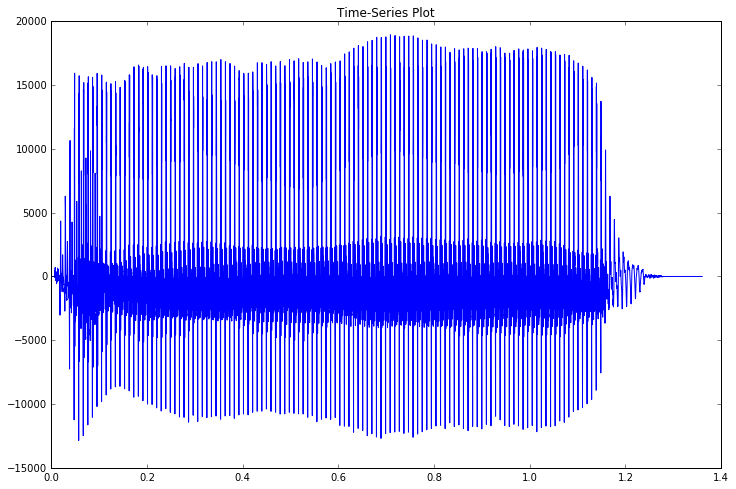

[  3   3   3   3   3   2   2   2   1   1   0   0  -1  -2  -3  -4  -4  -5
  -6  -7  -7  -8  -9  -9 -10 -10 -10 -10 -10 -10 -10 -10  -9  -9  -8  -8]
<proj_404.Signal instance at 0x7fd0b6208128>


ValueError: could not broadcast input array from shape (18) into shape (30000)

In [38]:
t_sax1.plot_fft_id(50)

# NMF - via Lee/Seung Method

My first try to get NMF to work, basic implementation according to the updates proposed by Lee and Seung.


In [69]:
def get_initial(m,n,p):
    # Get random starting W, H. We are doing random ints, can and SHOULD change
    W_init = np.random.randint(1,10,m*p).astype(float).reshape(m,p)
    H_init = np.random.randint(1,10,n*p).astype(float).reshape(p,n)
    return W_init, H_init

def update_H(_V, _W, _H):
    H_new = _H.copy()
    m, p = _H.shape
    top = _W.T.dot(_V)
    bottom = _W.T.dot(_W.dot(_H))
    for i in xrange(m):
        for j in xrange(p):
            H_new[i,j] *= top[i,j] / bottom[i,j]
    return H_new

def update_W(_V, _W, _H):
    W_new = _W.copy()
    p, n = _W.shape
    top = _V.dot(_H.T)
    bottom = _W.dot(_H.dot(_H.T))
    for i in xrange(p):
        for j in xrange(n):
            W_new[i,j] *= top[i,j] / bottom[i,j]
    return W_new

def nmf(V, p):
    m, n = V.shape
    W, H = get_initial(m, n, p)
    eps = 1.
    converged = False
    iters = 1
    
    while not converged and iters < 200:
        W_new = update_W(V, W, H)
        H_new = update_H(V, W, H)
        
        W = W_new.copy()
        H = H_new.copy()
        
        if la.norm(V - W.dot(H), 'fro') < eps:
            converged = True
        
        iters += 1
    print iters
    return W, H
    

